In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -d /content/gdrive/MyDrive/DL_Project

# !unzip /content/Flickr8k_Dataset.zip -d /content/gdrive/MyDrive/DL_Project
!unzip /content/Flickr8k_text.zip -d /content/gdrive/MyDrive/DL_Project

In [1]:
import tensorflow as tf

In [2]:
import string
import numpy as np
import pandas as pd 
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import tensorflow as tf
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
image_path = "./Flicker8k_Dataset"
dir_Flickr_text = "../urdu_cap_gen/Data/Data//KA_dogs.urd.descriptionsManual29Feb20.txt"

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 9890


In [4]:

file = open(dir_Flickr_text,'r', encoding='utf-8-sig')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split()
    # print(col)
    if len(col) <2:
        continue
    w = col[0]
    datatxt.append([w+".jpg"] + [" ".join(col[1:])])


data = pd.DataFrame(datatxt,columns=["filename","caption"])
data = data.reindex(columns =['filename','caption'])
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
data = data[data['filename'] != '3558251719_3af5ae2d02ایک.jpg']
data=data[data['filename'] != '430173345_86388d8282.jpg']


uni_filenames = np.unique(data.filename.values)
data.head()
data[data['filename'] == '3558251719_3af5ae2d02ایک.jpg']

data[data['filename'] == '430173345_86388d8282.jpg']
data

,filename,caption
0,1001773457_577c3a7d70.jpg,ایک سیاہ کتا اور ایک دھبوں والا کتا لڑ رہے ہیں
1,1001773457_577c3a7d70.jpg,سڑک پر ایک سیاہ کتا دوسرے سفید بھورے دھبوں وال...
2,1001773457_577c3a7d70.jpg,ایک سیاہ کتا اور ایک سفید بھورے دھبوں والا کتا...
3,1001773457_577c3a7d70.jpg,دو مختلف نسل کے کتے سڑک پر ایک دوسرے کو دیکھ ر...
4,1001773457_577c3a7d70.jpg,دو کتے فٹ پاتھ پر ایک دوسرے کی طرف بڑھ رہے ہیں
...,...,...
8990,989851184_9ef368e520.jpg,ایک سیاہ کتے کے منہ میں وزنی کھلونا ہے
8991,989851184_9ef368e520.jpg,ایک سیاہ کتے کے منہ میں وزنی کھلونا ہےجو نیلے ...
8992,989851184_9ef368e520.jpg,ایک سیاہ کتا جس کے منہ میں وزنی کھلونا ہے وہ ا...
8993,989851184_9ef368e520.jpg,ایک سیاہ کتا منہ میں ایک چھوٹا سا سفید کھلونا ...


In [5]:
# from keras.preprocessing.image import load_img, img_to_array

# npic = 5
# npix = 224
# target_size = (npix,npix,3)

# count = 1
# fig = plt.figure(figsize=(10,20))
# for jpgfnm in uni_filenames[10:15]:
#     filename = image_path + '/' + jpgfnm
#     captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
#     image_load = load_img(filename, target_size=target_size)
    
#     ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
#     ax.imshow(image_load)
#     count += 1
    
#     ax = fig.add_subplot(npic,2,count)
#     plt.axis('off')
#     ax.plot()
#     ax.set_xlim(0,1)
#     ax.set_ylim(0,len(captions))
#     for i, caption in enumerate(captions):
#         ax.text(0,i,caption,fontsize=20)
#     count += 1
# plt.show()

In [5]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 2470


In [6]:
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [7]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 8993
len(caption) : 8993


In [8]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [9]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [10]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 2399


In [11]:
PATH = "./Flicker8k_Dataset/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:3]

['<start>  ایک سیاہ کتا اور ایک دھبوں والا کتا لڑ رہے ہیں <end>',
 '<start>  سڑک پر ایک سیاہ کتا دوسرے سفید بھورے دھبوں والے کتے کے ساتھ کھیل رہا ہے <end>',
 '<start>  ایک سیاہ کتا اور ایک سفید بھورے دھبوں والا کتا گلی میں ایک دوسرے کو گھور رہے ہیں <end>']

In [12]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:3]

['./Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [13]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 8993
len(all_captions) : 8993


In [14]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [15]:
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [16]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 8993
len(all_captions) : 8993


In [17]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [18]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [19]:
# Get unique images
encode_train = sorted(set(img_name_vector))
output_path="./images3/"

In [23]:
# Get unique images
encode_train = sorted(set(img_name_vector))
output_path="./images3/"
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
os.mkdir(output_path)
for img, path in tqdm(image_dataset):
  # print(path)
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
   
    np.save(output_path+path_of_feature.split("/")[-1], bf.numpy())

100%|██████████| 113/113 [03:18<00:00,  1.76s/it]


### Preprocess and tokenize the captions

In [24]:
top_k = 5000

In [27]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

2402

In [28]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [25]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [26]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [27]:
cap_vector.shape

(8993, 34)

### Split the data into training and testing

In [28]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)
img_name_test,img_name_val,cap_test,cap_val=train_test_split(img_name_val,
                                                                    cap_val,
                                                                    test_size=0.5,
                                                                    random_state=0)

In [29]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val),len(img_name_test),len(cap_test)

(7194, 7194, 900, 900, 899, 899)

### Create a tf.data dataset for training

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
num_steps = len(img_name_train) // BATCH_SIZE

In [31]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
val_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [33]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [34]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [35]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [36]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [37]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [38]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [39]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [40]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [41]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [42]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [43]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [44]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [45]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [46]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [48]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

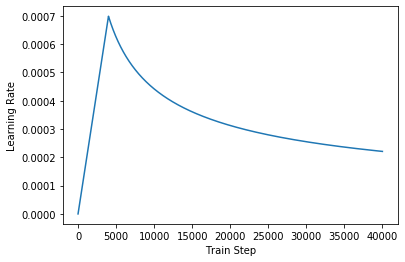

In [49]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [51]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [52]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
validation_loss = tf.keras.metrics.Mean(name='val_loss')

In [53]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [54]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [55]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [56]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  loss_sum = 0
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)
    loss_sum+=loss
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

@tf.function
def test_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    print(tar_inp,tar_real)
    loss_sum = 0
    dec_mask = create_masks_decoder(tar_inp)
    
    predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss=loss_function(tar_real,predictions)

    validation_loss(loss)
    
    val_acc_metric(tar_real,predictions)

In [57]:
loss_plot=[]
acc_plot=[]
val_loss=[]
val_acc=[]
for epoch in range(1):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    if (epoch + 1) % 5 == 0:
      ckpt_save_path = ckpt_manager.save()
      print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
      
  loss_plot.append(train_loss.result())
  acc_plot.append(train_accuracy.result())  

  validation_loss.reset_states()
  val_acc_metric.reset_states()
  for (val_batch,(img,target)) in enumerate(val_dataset):
    test_step(img,target)
  val_loss.append(validation_loss.result())
  val_acc.append(val_acc_metric.result())
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}, Val Loss {:.4f}, Val Acc {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),validation_loss.result(),val_acc_metric.result()))
  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 8.6946 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.0508 Accuracy 0.0166
Epoch 1 Batch 100 Loss 7.4657 Accuracy 0.0283
Tensor("strided_slice:0", shape=(64, 33), dtype=int32) Tensor("strided_slice_1:0", shape=(64, 33), dtype=int32)
Tensor("strided_slice:0", shape=(26, 33), dtype=int32) Tensor("strided_slice_1:0", shape=(26, 33), dtype=int32)
Epoch 1 Loss 7.3517 Accuracy 0.0317, Val Loss 6.2550, Val Acc 0.0671
Time taken for 1 epoch: 1094.795567035675 secs



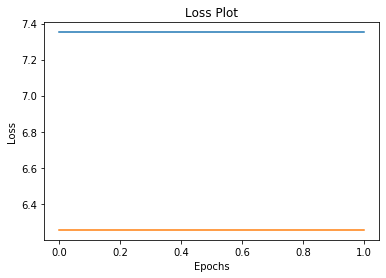

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  13658624  
                                                                 
 decoder (Decoder)           multiple                  19376640  
                                                                 
 dense_65 (Dense)            multiple                  2565513   
                                                                 
Total params: 35,600,777
Trainable params: 35,600,777
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Loss curve
plt.plot(loss_plot)
plt.plot(val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()
transformer.summary()

In [ ]:
transformer.save_weights('/content/gdrive/MyDrive/DL_Project/image_caption_transformer_50_inception.h5')

In [129]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = model(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 27.27272727272727
BLEU-2 score: 7.789982830837433e-153
BLEU-3 score: 1.7343040158223243e-183
BLEU-4 score: 1.3165594234639305e-229
Real Caption: ایک بھورا کتا گھاس پر بھاگ رہا ہے
Predicted Caption: ایک کتا کچھ پھولوں کے قریب سرسبز لان میں بھاگتا ہے


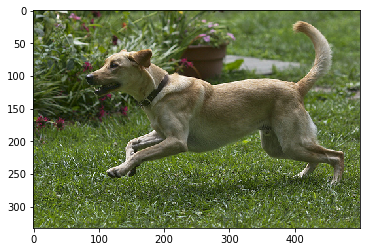

In [130]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


BLEU-1 score: 27.27272727272727
BLEU-2 score: 16.514456476895408
BLEU-3 score: 1.7175994813661398e-91
BLEU-4 score: 6.061838450024688e-153
Real Caption: تین سیاہ کتے ساحل پر ہیں
Predicted Caption: ایک سیاہ کتا ساحل پر پانی کے اوپر اچھل رہا ہے


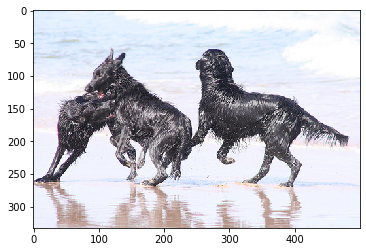

In [131]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


BLEU-1 score: 46.00222073146617
BLEU-2 score: 19.615412827794998
BLEU-3 score: 1.8419817303850457e-91
BLEU-4 score: 6.336877893084566e-153
Real Caption: منہ میں ایک گیند کے ساتھ کتا پانی کے میں چل رہا ہے
Predicted Caption: پیلے رنگ کا کتا کم گہرے پانی میں گیند پکڑ رہا ہے


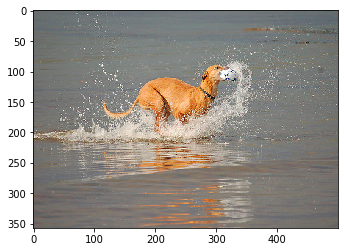

In [132]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


BLEU-1 score: 20.980356838155135
BLEU-2 score: 18.502935537050632
BLEU-3 score: 16.84881037229998
BLEU-4 score: 2.4581521049290788e-76
Real Caption: پیلی کشتی میں کا ایک گروہ اپنے کتوں کے ساتھ موجود ہے
Predicted Caption: تین کتے پیلی کشتی میں تیرتے ہیں


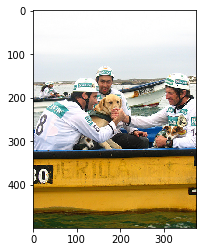

In [133]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


In [124]:
# # Save the checkpoint

# def save_checkpoint(model, path, epochs, optimizer, criterion, lr):

#     model.class_to_idx = data.class_to_idx

#     checkpoint = {'arch': "vgg16",
#                   'class_to_idx': model.class_to_idx,
#                   'model_state_dict': model.state_dict(),
#                   'epochs': epochs,
#                   'optimizer': optimizer,
#                   'criterion': criterion,
#                   'lr':lr
#                  }

#     torch.save(checkpoint, path)

# def load_checkpoint(filepath, map_location=torch.device('cpu')):
    
#     checkpoint = torch.load(filepath, map_location=map_location)
    
#     model = models.vgg16(pretrained=True)
        
#     for param in model.parameters():
#         param.requires_grad = False

#     model.class_to_idx = checkpoint['class_to_idx']

#     model.classifier[6] = nn.Linear(4096, 59)
#     model.load_state_dict(checkpoint['model_state_dict'])
    
#     return model, checkpoint


def load_model(model, name):
    model.load_weights('./'+name+'.h5')
    return model
def save_model(model, name):
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/DL_Project/'+name+'.h5')
# save_model(model, 'image_caption_transformer_45')
model=load_model(transformer,"image_caption_transformer_50_inception")

In [ ]:
# hidden_dim = 10
# input_dim = data.shape[1]
# num_layers = 2 
# train_size = 0.8
# val_split = 0.2
# no_of_layers = 2
# shuffle=True
# neurons_per_layer = 10
# loss_func = torch.nn.BCELoss()
# batch_size = 10
# learning_rate = 0.01

input_dim = data.shape[1]
training_epoch = 20
# model = RNN(input_dim,hidden_dim, num_layers)

# model = load_model(transformer, 'image_caption_transformer_45')
# transformer.load_weights('/content/gdrive/MyDrive/DL_Project/'+'image_caption_transformer_120_inceptionV3'+'.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['ایک',
 'بڑا',
 'کتا',
 'اپنے',
 'منہ',
 'میں',
 'کچھ',
 'پکڑے',
 'کیمرے',
 'کی',
 'جانب',
 'دیکھتا',
 'ہے']

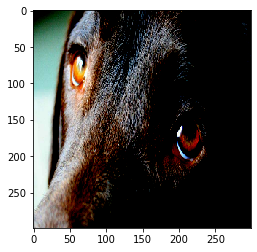

In [127]:
def test(image):
  plt.imshow(load_image(image)[0])
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = model(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights
image_path = tf.keras.utils.get_file('image'+'.png',
                                     origin='https://ichef.bbci.co.uk/news/976/cpsprodpb/726A/production/_107409292_dogeyes.jpg')
test(image_path)[0]

BLEU-1 score: 57.14285714285714
BLEU-2 score: 36.31365196012815
BLEU-3 score: 2.7557847058228826e-91
BLEU-4 score: 8.988913042377078e-153
Real Caption: ایک سیاہ کتا چٹان پر کھڑا ہے اس کے پیچھے سبز کھیت ہیں
Predicted Caption: ایک کھیت کی ایک بڑی چٹان پر سفید پنجوں والا سیاہ کتا کھڑا ہے


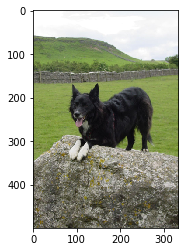

In [134]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


In [136]:
score = 0
for i in range (0,len(img_name_val),5):
    image = img_name_val[i]
    # print(cap_val[i],img_name_val[i])
    caption,result,weights = evaluate(image)
    # print(result)
    real = list(data[data['filename']==image.split("/")[-1]]['caption'])
    cleaned = []
    for i in range(len(real)):
        cleaned.append(real[i][7:-5])
    predicted = ' '.join(caption)
    score += sentence_bleu(cleaned, predicted)
val_bleu = score/len(img_name_val)*5
print("BLEU score on validation data: ",val_bleu)
# data

BLEU score on validation data:  0.7560489090489377


In [137]:
val_bleu

0.7560489090489377

In [138]:
from nltk.translate.bleu_score import corpus_bleu
score = 0
references=[]
hypothesis=[]
for i in range (0,len(img_name_val),5):
    image = img_name_val[i]
#     print(cap_val[i],img_name_val[i])
    caption,result,weights = evaluate(image)
    
    # print(result)
    real = list(data[data['filename']==image.split("/")[-1]]['caption'])
    cleaned = []
    for i in range(len(real)):
        cleaned.append(real[i].split())
    
    predicted = ' '.join(caption)
    references.append(cleaned)
    hypothesis.append(predicted.split())
    
    score += sentence_bleu(cleaned,predicted.split())
    

val_bleu = score/len(img_name_val)*5
print("BLEU score on validation data: ",val_bleu)
# data
bleu4 = corpus_bleu(references, hypothesis)#,weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=SmoothingFunction().method1)
bleu3 = corpus_bleu(references, hypothesis,weights=(0.33, 0.33, 0.33, 0.0))
bleu2 = corpus_bleu(references, hypothesis,weights=(0.5, 0.5, 0.0, 0.0))
bleu1 = corpus_bleu(references, hypothesis,weights=(1, 0.0, 0.0, 0.0))
print(bleu1,bleu2,bleu3,bleu4)

1.0 1.0
0.9099882808096075 1.9099882808096074
9.212002349967284e-155 1.9099882808096074
1.0 2.9099882808096074
0.7730551756939454 3.683043456503553
1.0 4.683043456503553
1.0 5.683043456503553
7.053663163619216e-155 5.683043456503553
1.0 6.683043456503553
1.0 7.683043456503553
1.0 8.683043456503553
5.218621439957678e-78 8.683043456503553
1.0 9.683043456503553
1.0 10.683043456503553
1.0 11.683043456503553
0.8694417438899827 12.552485200393535
4.986094240050794e-78 12.552485200393535
0.6729864884660303 13.225471688859566
1.0 14.225471688859566
2.9848605053832845e-78 14.225471688859566
1.0 15.225471688859566
1.0 16.225471688859564
1.0 17.225471688859564
1.0 18.225471688859564
0.4671379777282001 18.692609666587764
1.6034157163765524e-231 18.692609666587764
0.18185234853618296 18.874462015123946
1.0 19.874462015123946
1.0 20.874462015123946
0.8551002976753405 21.729562312799285
4.248671507762367e-78 21.729562312799285
6.513869329968086e-155 21.729562312799285
0.31271259461293593 22.042274907

In [ ]:
def test(image):
  plt.imshow(load_image(image)[0])
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights
# image_path = tf.keras.utils.get_file('image'+'.jpg',
#                                      origin='https://i.ytimg.com/vi/FHytoCvj90w/maxresdefault.jpg')
test('/content/maxresdefault.jpg')[0]

NotFoundError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['ایک', 'کتا', 'پانی', 'کے', 'قریب', 'ریت', 'میں', 'دوڑتا', 'ہے']

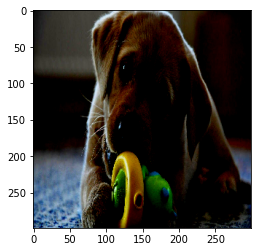

In [ ]:
test('/content/maxresdefault (1).jpg')[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['ایک', 'کتا', 'کھلے', 'منہ', 'کے', 'ساتھ', 'ایک', 'کھلونا', 'پکڑتا', 'ہے']

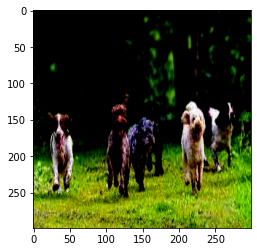

In [ ]:
test('/content/download.jpg')[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['ایک',
 'کتا',
 'ساحل',
 'سمندر',
 'پر',
 'گیند',
 'کے',
 'ساتھ',
 'کھیل',
 'رہا',
 'ہے']

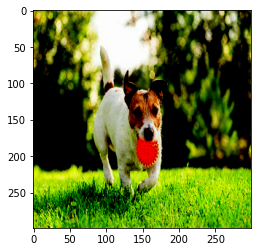

In [ ]:
test('/content/972752326-640w.jpg')[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TensorShape([1, 8, 12, 12])

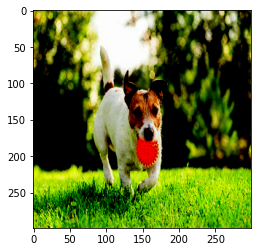

In [ ]:
test('/content/972752326-640w.jpg')[2]['decoder_layer1_block1'].shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['ایک', 'کتا', 'پانی', 'کے', 'قریب', 'ریت', 'پر', 'چلتا', 'ہے']

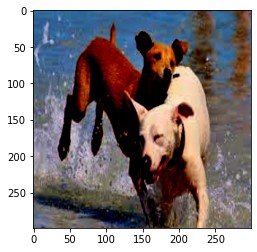

In [ ]:
test('/content/images (1).jpg')[0]

In [ ]:
print("hi")

hi


In [63]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

NameError: name 'attention_weights' is not defined

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])